В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import opendatasets as od
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


# Define functions
def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

def convert_to_categorical(df: pd.DataFrame, cat_cols: list[str]) -> pd.DataFrame:
    """
    Converts columns to categorical type.

    Args:
    df (pd.DataFrame): DataFrame.
    cat_cols (List[str]): Column names list for converting.

    Returns:
    pd.DataFrame: DataFrame with converted columns.
    """
    for col in cat_cols:
        df[col] = pd.Categorical(df[col])
    return df

def predict_and_metrics(model, inputs, targets, name):
  pred = model.predict(inputs)
  proba = model.predict_proba(inputs)[:,1]
  auc_score = roc_auc_score(targets, proba)
  print(classification_report(targets, pred, digits=4))
  print(f'AUROC at {name} set: {auc_score}', end = '\n\n')
  return pred, proba, auc_score


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Load dataset from Kaggle
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data'
od.download(dataset_url)
data_dir = './bank-customer-churn-prediction-dlu/'
raw_df_url = '{}train.csv'.format(data_dir)
raw_df = pd.read_csv(raw_df_url)

# Split data into train and test sets, separate input and target cols
train_df, val_df = split_train_val(raw_df, ['Exited'], 0.2, 42)
input_cols = raw_df.columns.tolist()[:-1]
target_col = raw_df.columns.tolist()[-1]
train_inputs, train_targets = separate_inputs_targets(train_df, input_cols, target_col)
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols, target_col)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: oksanarolduhina
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 71.0MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [4]:
categorical_cols = raw_df.select_dtypes(include = 'object').columns.tolist()
train_inputs = convert_to_categorical(train_inputs, categorical_cols)
val_inputs = convert_to_categorical(val_inputs, categorical_cols)

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [5]:
%time
# Define model
xgb_clf = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=15,
    enable_categorical=True,  # для категорійних ознак
    #use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    #device='cuda'
)

# Train model
xgb_clf.fit(train_inputs, train_targets)

# Predict and calculate model metrics
train_pred, train_proba, train_auc = predict_and_metrics(xgb_clf, train_inputs, train_targets, 'train')
val_pred, val_proba, val_auc = predict_and_metrics(xgb_clf, val_inputs, val_targets, 'validation')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
              precision    recall  f1-score   support

         0.0     0.9236    0.9682    0.9454      9558
         1.0     0.8465    0.6867    0.7583      2442

    accuracy                         0.9109     12000
   macro avg     0.8851    0.8275    0.8519     12000
weighted avg     0.9080    0.9109    0.9073     12000

AUROC at train set: 0.9483855110032136

              precision    recall  f1-score   support

         0.0     0.9127    0.9586    0.9351      2390
         1.0     0.7980    0.6410    0.7109       610

    accuracy                         0.8940      3000
   macro avg     0.8554    0.7998    0.8230      3000
weighted avg     0.8894    0.8940    0.8895      3000

AUROC at validation set: 0.9272751903422731



**Висновки**

* Модель гарна (хоча є потенціал для покращення через тюнинг гіперпараметрів). Немає ані high bias (значення AUC Score високі), ні high variance (значення AUC Score на тренувальній вибірці несуттєво вище, ніж на валідаційній).

* У порівнянні з попереднім варіантом, вийшло покращити модель. Результати попередніх розрахунків та параметри подані нижче:

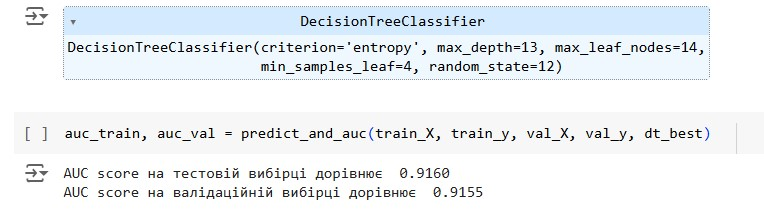

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [6]:
# Define objective function
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        #verbose = 2,
        #use_label_encoder=False,
        missing=np.nan,
        #device='cuda',
        early_stopping_rounds=10,
        seed=42
    )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False)
    pred = clf.predict_proba(val_inputs)[:,1]
    auc_score = roc_auc_score(val_targets, pred)

    return {'loss': -auc_score, 'status': STATUS_OK}

# Define hyperparameters space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Optimize parameters
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials, rstate=np.random.default_rng(42))

# Convert hyperparameters values into final types
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

print("Best hyperparameters: ", best_params)

# Train final model with best hyperparameters
final_clf = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    enable_categorical=True,
    #use_label_encoder=False,
    missing=np.nan,
    #device='cuda',
)

final_clf.fit(train_inputs, train_targets)

# Predict and calculate metrics
final_train_pred, final_train_proba, final_xgb_train_auc = predict_and_metrics(final_clf, train_inputs, train_targets, 'train')
final_val_pred, final_val_proba, final_xgb_val_auc = predict_and_metrics(final_clf, val_inputs, val_targets, 'validation')

100%|██████████| 20/20 [00:09<00:00,  2.13trial/s, best loss: -0.9362603745112834]
Best hyperparameters:  {'colsample_bytree': 0.6067573744197314, 'gamma': 0.16256825675622438, 'learning_rate': 0.012633189134943037, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 250, 'reg_alpha': 0.816994764213365, 'reg_lambda': 0.8140834674473612, 'subsample': 0.9411338024873159}
              precision    recall  f1-score   support

         0.0     0.9266    0.9798    0.9525      9558
         1.0     0.8980    0.6962    0.7843      2442

    accuracy                         0.9221     12000
   macro avg     0.9123    0.8380    0.8684     12000
weighted avg     0.9208    0.9221    0.9182     12000

AUROC at train set: 0.9597737610920285

              precision    recall  f1-score   support

         0.0     0.9101    0.9657    0.9371      2390
         1.0     0.8233    0.6262    0.7114       610

    accuracy                         0.8967      3000
   macro avg     0.8667    0.7960    0.8

**Висновки**

1. Модель гарна, немає high bias та high variance.
2. Модель покращилась у порівнянні з попереднім варіантом (без оптимізації гіперпараметрів). AUROC на валідаційному сеті покращилась до 0,9369 (було 0,9273)

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [9]:
%%time
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in categorical_cols]

lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=20,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,
    missing=np.nan,
    verbose=3,
    #device='cuda'
)

lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

train_pred, train_proba, train_auc = predict_and_metrics(lgb_clf, train_inputs, train_targets, 'train')
val_pred, val_proba, val_auc = predict_and_metrics(lgb_clf, val_inputs, val_targets, 'val')


[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=2,4,5, categorical_column=2,4,5 will be ignored. Current value: categorical_feature=2,4,5
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.679694
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.233071
[LightGBM] [Debug] init for col-wise cost 0.001772 seconds, init for row-wise cost 0.002446 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

**Висновки**

1. Модель гарна, немає high bias та high variance (високий AUROC на тренувальному та валідаційному сетах, 0.9328/0.9255 ; AUROC на тренувальному сеті несуттєво вищий, ніж на валідаційному).
1. Модель lighgbm без оптимізації параметрів дала гірший результат, ніж XGBoost без оптимізації параметрів (0.9255 / 0.9272). Кращий результат поки дає XGBoost з оптимізацією параметрів (AUROC 0.9369).

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [10]:
%%time
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_split_gain=params['min_split_gain'],
        cat_feature=cat_feature_indexes,
        verbose=3
    )

    clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
    pred = clf.predict_proba(val_inputs)[:,1]
    auc_score = roc_auc_score(val_targets, pred)

    return {'loss': -auc_score, 'status': STATUS_OK}

# Hyperparameters space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
}

# Optimization
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials, rstate=np.random.default_rng(42))

# Convert hyperparameters values into final types
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

print("Best hyperparameters: ", best_params)

# Train final model with best hyperparameters
final_lgb_clf = lgb.LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    num_leaves=best_params['num_leaves'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    min_split_gain=best_params['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

# Predict and calculate metrics
final_lgb_train_pred, final_lgb_train_proba, final_lgb_train_auc = predict_and_metrics(final_lgb_clf, train_inputs, train_targets, 'train')
final_lgb_val_pred, final_lgb_val_proba, final_xgb_val_auc = predict_and_metrics(final_lgb_clf, val_inputs, val_targets, 'validation')


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Warning

**Висновки**

В результаті тюнингу гіперпараметрів вийшло покращити метрику моделі (АUROC 0.9351, попередній результат 0.9255). Але найкраще значення дала модель XGBoost.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [11]:
test_raw_df = pd.read_csv('{}/test.csv'.format(data_dir))
test_inputs = convert_to_categorical(test_raw_df[input_cols], categorical_cols)
test_raw_df['Exited'] = final_clf.predict_proba(test_inputs)[:,1]
submission_df = test_raw_df[['id','Exited']].copy()
submission_df.to_csv('submission.csv', index = False)

**Висновки**

Найкращий результат з усіх розглянутих показала модель XGBoost з тюнингом гіперпараметрів (AUROC 0.9369), вона і була обрана як фінальна.